# Maximizar Utilidad

El modelo estándar de portafolio de media-varianza (Markowitz) determina un portafolio de inversión óptimo que equilibra el riesgo y el rendimiento esperado


In [5]:
import gurobipy as gp
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

## Datos de Entrada

Los siguientes datos de entrada se utilizan en el modelo:

- $S$: conjunto de acciones
- $\mu$: vector de rendimientos esperados
- $\Sigma$: matriz de varianza-covarianza
    - $\sigma_{ij}$ covarianza entre los rendimientos de los activos $i$ y $j$
    - $\sigma_{ii}$ varianza del rendimiento del activo $i$

In [6]:
# Importar datos
Sigma = pd.read_pickle("sigma.pkl")
mu = pd.read_pickle("mu.pkl")

## Formulación

El modelo maximiza el rendimiento esperado total para un nivel fijo de varianza (riesgo) preespecificado. Matemáticamente, esto resulta en un problema de optimización convexa con restricciones cuadráticas.

### Variables de Decisión y Cotas de las Variable

Las variables de decisión en el modelo son las proporciones de capital invertidas entre las acciones consideradas. El vector correspondiente de posiciones se denota por $x$, donde su componente $x_i$ representa la proporción de capital invertido en la acción $i$.

Cada posición debe estar entre 0 y 1; esto evita el apalancamiento y la venta en corto:

$$0\leq x_i\leq 1 \; , \;  i \in S$$


###  Restricciones
La restricción presupuestaria garantiza que todo el capital esté invertido:

$$\sum_{i \in S} x_i =1$$

El riesgo estimado debe ser igual al nivel de varianza admisible preespecificado $\bar\sigma^2$:

$$x^\top \Sigma x = \bar\sigma^2$$

###  Función Objetivo
El objetivo es maximizar el rendimiento esperado del portafolio:

$$\max_x \mu^\top x $$

Usando gurobipy, esto se puede expresar de la siguiente manera:

In [7]:
V = 100  # varianza (sigma^2)

# Crear un modelo de optimización vacío
m = gp.Model()

# Agregar variables: x[i] denota la proporción invertida en la acción i
# 0 <= x[i] <= 1
x = m.addMVar(len(mu), lb=0, ub=1, name="x")

# Restricción presupuestaria: todas las inversiones suman 1
m.addConstr(x.sum() == 1, name="Restriccion_Presupuesto")

# Límite en la varianza
restriccion_riesgo = m.addConstr(x @ Sigma.to_numpy() @ x == V, name="restriccion_riesgo")

m.params.MIPGap = 0
m.params.FeasibilityTol = 1e-9
m.params.OptimalityTol = 1e-9
m.params.NonConvex = 2

# Definir la función objetivo: Maximizar el rendimiento esperado
m.setObjective(mu.to_numpy() @ x, gp.GRB.MAXIMIZE)

Set parameter MIPGap to value 0
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter NonConvex to value 2


Resolvemos:

In [8]:
m.optimize()

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1 rows, 10 columns and 10 nonzeros
Model fingerprint: 0x95858578
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+01, 4e+02]
  Objective range  [4e-02, 3e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
  QRHS range       [1e+02, 1e+02]

Continuous model is non-convex -- solving as a MIP

Presolve time: 0.00s
Presolved: 212 rows, 65 columns, 475 nonzeros
Presolved model has 55 bilinear constraint(s)
Variable types: 65 continuous, 0 integer (0 binary)

Root relaxation: objective 2.078662e+00, 3 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    2.07866    0    3  

Mostrar los datos básicos de la solución:

In [9]:
print(f"Varianza:         {x.X @ Sigma @ x.X:.6f}")
print(f"Tiempo de solución:    {m.Runtime:.2f} segundos\n")

# Imprimir inversiones (con valores no despreciables, es decir, > 1e-8)
positions = pd.Series(name="Posición", data=x.X, index=mu.index)
print(f"Número de transacciones: {positions[positions > 1e-8].count()}\n")
print(positions[positions > 1e-8])

Varianza:         100.000000
Tiempo de solución:    0.07 segundos

Número de transacciones: 2

IANSA Cierre Ix    0.446644
ZOFRI Cierre Ix    0.553356
Name: Posición, dtype: float64


## Frontera Eficiente

La frontera eficiente revela el equilibrio entre riesgo y retorno en los portafolios de inversión. Muestra el mejor nivel de retorno esperado que se puede lograr para un nivel de riesgo especificado.
Calculamos esto resolviendo el problema de optimización anterior para una muestra de niveles de riesgo admisibles.

En primer lugar, debemos determinar el portafolio de mínimiza varianza

El modelo minimiza el riesgo del portafolio.

### Variables de Decisión y Cotas de las Variable

Las variables de decisión en el modelo son las proporciones de capital invertidas entre las acciones consideradas. El vector correspondiente de posiciones se denota por $x$, donde su componente $x_i$ representa la proporción de capital invertido en la acción $i$.

Cada posición debe estar entre 0 y 1; esto evita el apalancamiento y la venta en corto:

$$0\leq x_i\leq 1 \; , \;  i \in S$$


###  Restricciones
La restricción presupuestaria garantiza que todo el capital esté invertido:

$$\sum_{i \in S} x_i =1$$

###  Función Objetivo
El objetivo es minimizar el riesgo del portafolio:

$$\min_x \frac{1}{2} x^\top \Sigma x $$

Usando gurobipy, esto se puede expresar de la siguiente manera:

In [10]:
# Crear un modelo de optimización vacío
min_var = gp.Model()

# Agregar variables: x[i] denota la proporción invertida en la acción i
# 0 <= x[i] <= 1
x_min_var = min_var.addMVar(len(mu), lb=0, ub=1, name="x")

# Restricción presupuestaria: todas las inversiones suman 1
min_var.addConstr(x_min_var.sum() == 1, name="Restriccion_Presupuesto")

min_var.params.MIPGap = 0
min_var.params.FeasibilityTol = 1e-9
min_var.params.OptimalityTol = 1e-9

# Definir la función objetivo: Minimizar el riesgo esperado
min_var.setObjective((1/2)* x_min_var @ Sigma.to_numpy() @ x_min_var, gp.GRB.MINIMIZE)

min_var.optimize()

min_std = np.sqrt(2*min_var.ObjVal)

print(f"Varianza Mínima:  {2*min_var.ObjVal:.6f}")

Set parameter MIPGap to value 0
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1 rows, 10 columns and 10 nonzeros
Model fingerprint: 0xbe8e419f
Model has 55 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [1e+01, 4e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.01s
Presolved: 1 rows, 10 columns, 10 nonzeros
Presolved model has 55 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 9
 AA' NZ     : 4.500e+01
 Factor NZ  : 5.500e+01
 Factor Ops : 3.850e+02 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual

Con el nivel mínimo de riesgo, podemos dibujar la frontera eficiente para distintos niveles de riesgo:

In [11]:
# Extraer la diagonal
diagonal = np.sqrt(np.diag(Sigma))

# Mejor índice en términos de retorno
indice_mayor_mu = np.argmax(mu)

riesgos = np.linspace(min_std, diagonal[indice_mayor_mu], 50)
retornos = np.zeros(riesgos.shape)
npos = np.zeros(riesgos.shape)

# ocultar la salida de log de Gurobi
m.params.OutputFlag = 0

# resolver el modelo para cada nivel de riesgo
for i, nivel_riesgo in enumerate(riesgos):
    # establecer el nivel de riesgo: lado derecho de la restricción de riesgo
    restriccion_riesgo.setAttr('QCRHS', nivel_riesgo**2)
    m.optimize()
    # almacenar datos
    retornos[i] = mu @ x.X
    npos[i] = len([xi for xi in x.X if xi > 1e-5])

A continuación, mostramos la frontera eficiente para este modelo: graficamos los rendimientos esperados (en el eje $y$) frente a la desviación estándar $\sqrt{x^\top\Sigma x}$ de los rendimientos esperados (en el eje $x$). También mostramos la relación entre el riesgo y el número de posiciones en el portafolio óptimo.

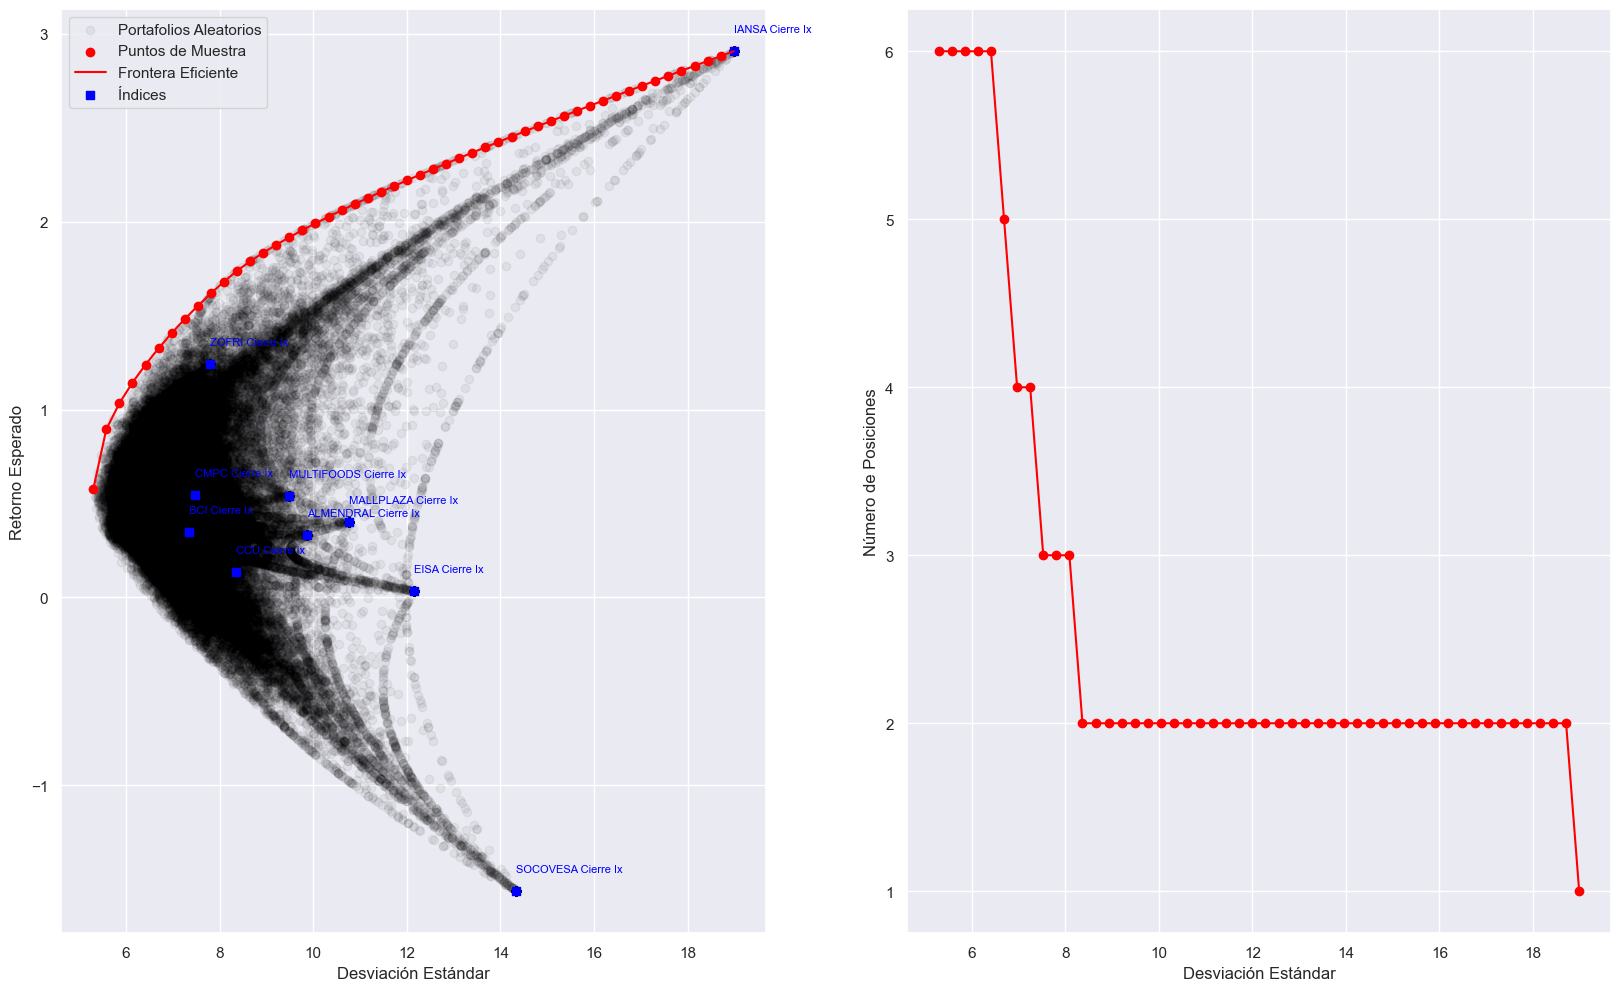

In [12]:
# Generación de portafolios
num_portfolios = 100000
num_indices = len(mu)

retornos_aleatorios = np.zeros(num_portfolios)
volatilidades_aleatorias = np.zeros(num_portfolios)

for i in range(num_portfolios):
    # Generar portafolios
    if np.random.rand() > 0.8:
        # Portafolios balanceados
        pesos = np.random.dirichlet(np.ones(num_indices) * np.random.uniform(0.1, 200), size=1)[0]
    else:
        # Portafolios Extremos
        pesos = np.zeros(num_indices)
        num_picked_assets = np.random.randint(1, num_indices)  # Randomly select how many assets to invest in
        picked_assets = np.random.choice(num_indices, num_picked_assets, replace=False)
        pesos[picked_assets] = np.random.rand(num_picked_assets)
        pesos /= np.sum(pesos)  # Normalizar la suma
    
    # Calcular retorno esperado
    retornos_aleatorios[i] = np.dot(pesos, mu)
    
    # Calcular volatilidad
    portfolio_variance = np.dot(pesos.T, np.dot(Sigma, pesos))
    volatilidades_aleatorias[i] = np.sqrt(portfolio_variance)

index_names = list(mu.index)
index_returns = list(mu)
index_volatilities = np.sqrt(np.diag(Sigma))


fig, axs = plt.subplots(1, 2, figsize=(20, 12))

# Random portfolios
axs[0].scatter(x=volatilidades_aleatorias, y=retornos_aleatorios, marker="o", label="Portafolios Aleatorios", color="Black", alpha=0.05)

# La frontera eficiente
axs[0].scatter(x=riesgos, y=retornos, marker="o", label="Puntos de Muestra", color="Red")
axs[0].plot(riesgos, retornos, label="Frontera Eficiente", color="Red")

# Plot indices
axs[0].scatter(x=index_volatilities, y=index_returns, marker="s", color="Blue", label="Índices")
for i, name in enumerate(index_names):
    axs[0].annotate(name, (index_volatilities[i], index_returns[i]+0.1), fontsize=8, color="Blue")


axs[0].set_xlabel("Desviación Estándar")
axs[0].set_ylabel("Retorno Esperado")
axs[0].legend()

# El número de posiciones activas
axs[1].scatter(x=riesgos, y=npos, color="Red")
axs[1].plot(riesgos, npos, color="Red")
axs[1].set_xlabel("Desviación Estándar")
axs[1].set_ylabel("Número de Posiciones")

plt.show()

Como era de esperar, el número de posiciones abiertas disminuye a medida que permitimos más varianza; la optimización invertirá progresivamente en activos de alto riesgo, pero con altos rendimientos.